In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

In [12]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

a = fetch_data(subjects=np.arange(19), recording=[1,2])

print(len(a))

# fetch_data(subjects=list(range(20)), recording=[1,2])

Using default location ~/mne_data for PHYSIONET_SLEEP...
Using default location ~/mne_data for PHYSIONET_SLEEP...
37


In [3]:
alice_files

['C:\\Users\\murco.DESKTOP-R324UUU\\mne_data\\physionet-sleep-data\\SC4001E0-PSG.edf',
 'C:\\Users\\murco.DESKTOP-R324UUU\\mne_data\\physionet-sleep-data\\SC4001EC-Hypnogram.edf']

In [4]:
# read_raw_filetype function to read data into object I suppose

raw_train = mne.io.read_raw_edf(alice_files[0])

annot_train = mne.read_annotations(alice_files[1])

Extracting EDF parameters from C:\Users\murco.DESKTOP-R324UUU\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [5]:
print(raw_train)
print(raw_train.info)

<RawEDF  |  SC4001E0-PSG.edf, n_channels x n_times : 7 x 7950000 (79500.0 sec), ~19 kB, data not loaded>
<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG submental, Temp rectal, Event marker
    chs : list | 7 items (EEG: 7)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 50.0 Hz
    meas_date : tuple | 1989-04-24 16:13:00 GMT
    nchan : int | 7
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 100.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType


In [6]:
print(dir(annot_train)) 

print(annot_train.description)

print(annot_train.duration.sum())

['__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_sort', 'append', 'copy', 'crop', 'delete', 'description', 'duration', 'onset', 'orig_time', 'save']
['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3'
 'Sleep stage 2' 'Sleep stage 3' 'Sleep stage 4' 'Sleep stage 3'
 'Sleep stage 4' 'Sleep stage 3' 'Sleep stage 4' 'Sleep stage 3'
 'Sleep stage 4' 'Sleep stage W' 'Sleep stage 3' 'Sleep stage 2'
 'Sleep stage 3' 'Sleep stage 4' 'Sleep stage 3' 'Sleep stage 4'
 'Sleep stage 2' 'Sleep stage 3' 'Sleep stage 2' 'Sleep stage 3'
 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3' 'Sleep stage 2'
 'Sleep stage 3' 'Sl

Effective window size : 20.480 (s)


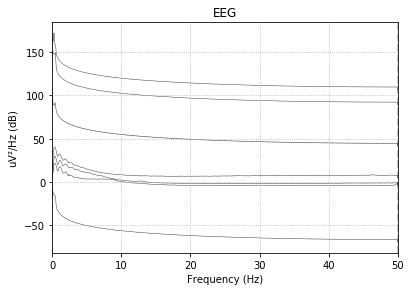

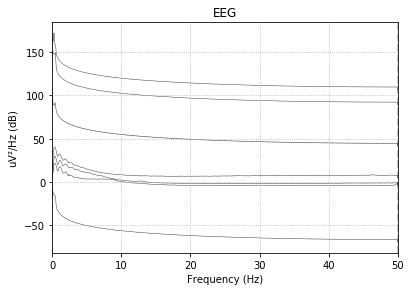

In [7]:
# Power spectral density maps. Not sure what those are exactly

raw_train.plot_psd(spatial_colors=False)


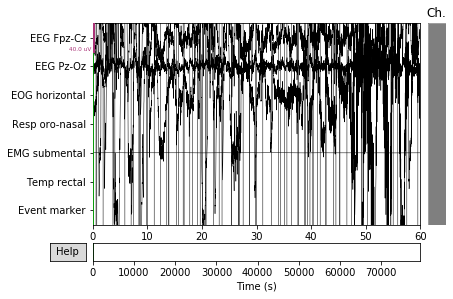

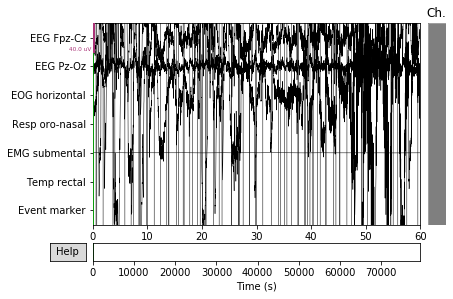

In [8]:
# total duration seems to be 86400 seconds, which is 24 hours?

raw_train.plot(duration=60, n_channels=7)

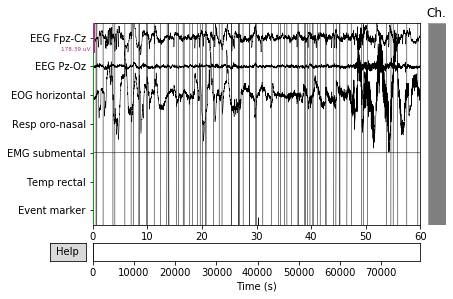

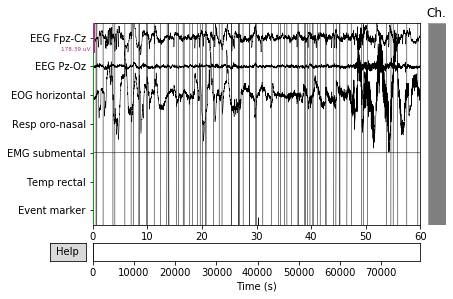

In [9]:
raw_train.plot(duration=60, scalings='auto')

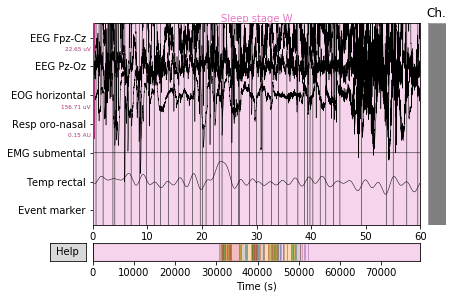

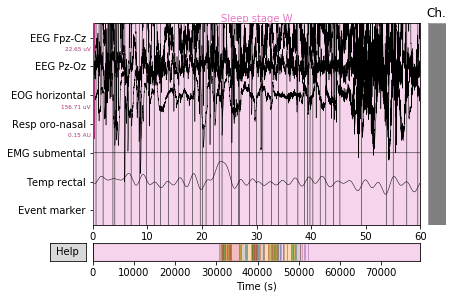

In [10]:
mapping = {'EEG Fpz-Cz': 'eeg',
           'EEG Pz-Oz': 'eeg',
           'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_train.set_annotations(annot_train, emit_warning=False)

# set_channel arguments: 
# ecg, eeg, emg, eog, exci, ias, misc, resp, seeg, stim, syst, ecog, hbo, hbr, fnirs_raw, fnirs_od
raw_train.set_channel_types(mapping)

# print(raw_train.info)

# plot some data
raw_train.plot(duration=60, scalings='auto')

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


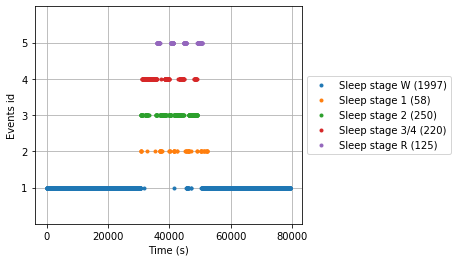

In [11]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

#  events from annotation method

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
mne.viz.plot_events(events_train, event_id=event_id,
                    sfreq=raw_train.info['sfreq'])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [12]:
# also set tmax to 15 instead of 30 to decrease dimensionality

tmax = 15. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None, preload=True)

print(epochs_train)

# Downsampling to 25 Hz from 100 Hz so I can use SVM

epochs_train = epochs_train.resample(25., npad='auto')

2650 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2650 events and 1500 original time points ...
0 bad epochs dropped
<Epochs  |   2650 events (all good), 0 - 14.99 sec, baseline off, ~212.3 MB, data loaded,
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125
 'Sleep stage W': 1997>


In [13]:
dir(epochs_train)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bad_dropped',
 '_channel_type_idx',
 '_check_consistency',
 '_check_metadata',
 '_compute_aggregate',
 '_current',
 '_data',
 '_decim',
 '_decim_slice',
 '_detrend_offset_decim',
 '_do_delayed_proj',
 '_evoked_from_epoch_data',
 '_filename',
 '_get_channel_positions',
 '_get_data',
 '_get_epoch_from_raw',
 '_getitem',
 '_is_good_epoch',
 '_keys_to_idx',
 '_metadata',
 '_name',
 '_offset',
 '_pick_drop_channels',
 '_project_epoch',
 '_projector',
 '_raw',
 '_raw_times',
 '_reject_setup',
 '_reject_time',
 '_set_channel_positions',
 '_set_times',
 '_si

In [14]:
print(epochs_train.info)

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG submental, Temp rectal, Event marker
    chs : list | 7 items (EEG: 2, EOG: 1, MISC: 4)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 12.5 Hz
    meas_date : tuple | 1989-04-24 16:13:00 GMT
    nchan : int | 7
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 25.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    me

In [15]:
x = epochs_train.get_data()

In [16]:
x.shape

# 2650 events, 7 channels, 30 seconds at 100 Hz

(2650, 7, 375)

In [17]:
print(epochs_train.event_id)
print(epochs_train.events[:,2])

labels = epochs_train.events[:,2]
EEG_pz_z = x[:,0,:]

{'Sleep stage W': 1, 'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3/4': 4, 'Sleep stage R': 5}
[1 1 1 ... 1 1 1]


In [18]:
print(EEG_pz_z.shape, labels.shape)

# print(type(EEG_pz_z))



# x = np.column_stack([EEG_pz_z, labels])

# x = np.concatenate((EEG_pz_z, labels), axis=0)

# print(np.asarray([EEG_pz_z, labels]).shape)

(2650, 375) (2650,)


In [19]:
zipped = zip(EEG_pz_z, labels)

no_wake = list(filter( lambda x: x[1] != 1, list(zipped)))
print(no_wake[0])


(array([ 2.20321503e-07,  5.24971319e-06,  3.81204061e-06,  1.09494527e-06,
        4.07358938e-06, -1.16988873e-07, -1.72696304e-06,  1.02758369e-05,
        1.37116020e-05,  6.49473594e-06, -1.68036552e-06,  1.36426105e-06,
       -3.36164979e-06, -7.34501232e-06,  1.47312809e-06, -6.51425732e-08,
       -7.28295560e-06,  6.61277715e-06,  1.31402439e-05,  1.58029934e-06,
        4.20271162e-06,  6.78971135e-06, -3.79891789e-06, -2.20299883e-06,
       -3.00215139e-06, -1.92727122e-06,  2.22329557e-06, -7.63184878e-07,
       -8.80052250e-06, -2.08604328e-06,  2.46817333e-06, -8.12967335e-06,
       -4.11805186e-06,  1.85680619e-06, -5.46594816e-06, -1.27131526e-05,
        2.60059033e-06, -1.28843739e-05, -1.19785247e-05,  3.07287142e-06,
       -1.87425268e-06, -8.67940277e-06,  5.85577532e-06,  5.70813375e-06,
        2.80099637e-06,  5.08997961e-06,  9.06376394e-06, -4.31243111e-06,
        3.36914447e-06, -4.46191399e-06, -6.78470693e-06, -2.15871281e-07,
        9.19448572e-07, 

In [20]:
# print(np.asarray(no_wake[:][0]))

In [21]:
no_wake = np.asarray(no_wake)
print(no_wake.shape[0], no_wake[0][0].shape[0])

event_count = no_wake.shape[0]
event_size = no_wake[0][0].shape[0]

# This is ugly but it works so whatever

no_wake_data = np.vstack(no_wake[:,0]).reshape([event_count,event_size, 1])

no_wake_labels = np.vstack(no_wake[:,1]).reshape([event_count])


print(no_wake_data.shape, no_wake_labels.shape)

653 375
(653, 375, 1) (653,)


In [22]:
# 653 non_wake events, 3000 datapoints per

# 653 * 30 seconds = 19590 seconds = 5.44 hours of áctual 'sleep'

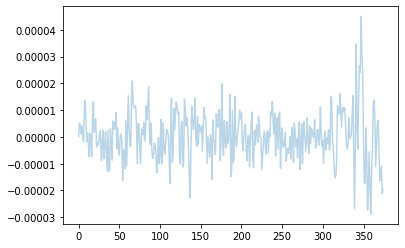

In [23]:
import matplotlib.pyplot as plt


plt.plot(no_wake_data[0,:,:], alpha=0.3)
plt.show()

# eh it's probably fine.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [25]:
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.svm import TimeSeriesSVC

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(no_wake_data, no_wake_labels, test_size=0.33, random_state=42)

# print(no_wake_labels.size, y_train.size, y_test.size)

In [27]:

# Correct classification rate: 0.5787037037037037
if False:

    np.random.seed(0)

    # X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

    X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
    X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

    # https://tslearn.readthedocs.io/en/latest/auto_examples/plot_svm.html

    clf = TimeSeriesSVC(kernel="gak",
                        gamma=.1)
    clf.fit(X_train, y_train)
    print("Correct classification rate:", clf.score(X_test, y_test))

    n_classes = len(set(y_train))

    plt.figure()
    support_vectors = clf.support_vectors_time_series_(X_train)
    for i, cl in enumerate(set(y_train)):
        plt.subplot(n_classes, 1, i + 1)
        plt.title("Support vectors for class %d" % (cl))
        for ts in support_vectors[i]:
            plt.plot(ts.ravel())

    plt.tight_layout()
    plt.show()

In [28]:
print(X_train.shape, X_test.shape, np.asarray(no_wake_data.shape))

(437, 375, 1) (216, 375, 1) [653 375   1]


In [29]:
print(y_train.shape, y_test.shape)

data = np.concatenate((X_train, X_test))
labels = np.concatenate((y_train, y_test))
print(data.shape, labels.shape)

partition = {'train': [str(x) for x in np.arange(0,y_train.size)],
             'validation': [str(x) for x in np.arange(y_train.size,y_train.size + y_test.size)]}

# print(labels)
labels_dict = {}
for i, label in enumerate(labels):
    labels_dict[str(i)] = label-2


# print(labels_dict)
# print(partition['train'])

(437,) (216,)
(653, 375, 1) (653,)


In [30]:
import torch
#  making data

for i, signal in enumerate(data):
    signal = torch.from_numpy(signal)
    
    torch.save(signal, 'data/' + str(i) + '.pt')

In [31]:
"""
This module implements a Convolutional Neural Network in PyTorch.
You should fill in code into indicated sections.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict

class ConvNet(nn.Module):
    """
  This class implements a Convolutional Neural Network in PyTorch.
  It handles the different layers and parameters of the model.
  Once initialized an ConvNet object can perform forward.
  """

    def __init__(self, n_channels, n_classes):
        super(ConvNet, self).__init__()
        """
        Initializes ConvNet object.

        Args:
          n_channels: number of input channels
          n_classes: number of classes of the classification problem

        """
        self.layers = OrderedDict()

        self.layers["conv_1"] = nn.Conv1d(n_channels, 64, 8, stride=1, padding=1)
        self.layers["batchnorm_1"] = nn.BatchNorm1d(64)
        self.layers["relu_1"] = nn.ReLU(inplace=True)
        self.layers["maxpool_1"] = nn.MaxPool1d(8, stride=2, padding=1)

        self.layers["conv_2"] = nn.Conv1d(64, 128, 8, stride=1, padding=1)
        self.layers["batchnorm_2"] = nn.BatchNorm1d(128)
        self.layers["relu_2"] = nn.ReLU(inplace=True)
        self.layers["maxpool_2"] = nn.MaxPool1d(8, stride=2, padding=1)

        self.layers["conv_3"] = nn.Conv1d(128, 256, 8, stride=1, padding=1)
        self.layers["batchnorm_3"] = nn.BatchNorm1d(256)
        self.layers["relu_3"] = nn.ReLU(inplace=True)
        self.layers["maxpool_3"] = nn.MaxPool1d(8, stride=2, padding=1)

#         self.layers["conv_3"] = nn.Conv1d(128, 256, 8, stride=1, padding=1)
#         self.layers["batchnorm_3"] = nn.BatchNorm1d(256)
#         self.layers["relu_3"] = nn.ReLU(inplace=True)
#         self.layers["maxpool_3"] = nn.MaxPool1d(8, stride=2, padding=1)


        self.convoluter = nn.Sequential(self.layers)

        self.classifier = nn.Sequential(nn.Linear(9984, n_classes))
        print("Created model : {}".format(self))


    def forward(self, x):
        """
        Performs forward pass of the input. Here an input tensor x is transformed through
        several layer transformations.

        Args:
          x: input to the network
        Returns:
          out: outputs of the network

        """

        out = self.convoluter(x)

        # desired = (BATCHSIZE, 512)
        print(out.shape)
        out = out.view(x.shape[0], -1)
        print(out.shape)
        out = self.classifier(out)


        return out


In [32]:
import torch
from torch.utils import data

from dataset import Dataset
import torch.nn as nn
import torch.optim as optim


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
# device = torch.device("cuda:0" if use_cuda else "cpu")
device = 'cpu'
# cudnn.benchmark = True

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0}
max_epochs = 1

# Datasets
# partition = partition
labels = labels_dict

# Generators

training_set = Dataset(partition['train'], labels)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = data.DataLoader(validation_set, **params)


# models

network = ConvNet(1, 4)
network.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=1e-4)



# Loop over epochs
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        print(local_batch.shape, local_labels.shape)
        x = local_batch.view([64, 1, 375]).type(torch.cuda.FloatTensor).to(device)
        y = local_labels.type(torch.cuda.LongTensor).to(device)

        out = network.forward(x)
        loss = criterion(out, y)
        print(loss)
        print("hello")
        print("epoch: {} Loss {}".format(epoch, loss.item()))
#         acc = accuracy(out, y)
#         print("Accuracy: {}".format(acc))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Validation
#     with torch.set_grad_enabled(False):
#         for local_batch, local_labels in validation_generator:
#             # Transfer to GPU
#             local_batch, local_labels = local_batch.to(device), local_labels.to(device)

#             # Model computations
#             [...]

Created model : ConvNet(
  (convoluter): Sequential(
    (conv_1): Conv1d(1, 64, kernel_size=(8,), stride=(1,), padding=(1,))
    (batchnorm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_1): ReLU(inplace=True)
    (maxpool_1): MaxPool1d(kernel_size=8, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_2): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=(1,))
    (batchnorm_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_2): ReLU(inplace=True)
    (maxpool_2): MaxPool1d(kernel_size=8, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_3): Conv1d(128, 256, kernel_size=(8,), stride=(1,), padding=(1,))
    (batchnorm_3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_3): ReLU(inplace=True)
    (maxpool_3): MaxPool1d(kernel_size=8, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(i

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at C:\w\1\s\tmp_conda_3.7_183424\conda\conda-bld\pytorch_1570818936694\work\aten\src\THNN/generic/ClassNLLCriterion.c:97

In [ ]:
import torch

torch.cuda.is_available()